In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('amazon_baby_subset.csv')
data.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [4]:
with open('important_words.json','r') as f:
    imp_words = json.load(f)
len(imp_words)

193

## Remove punctuation

In [6]:
def remove_punctuation(text):
    text = str(text)
    import string
    return text.translate( text.maketrans('','',string.punctuation) ) 

In [7]:
data['review_clean'] = data['review'].apply(remove_punctuation)

In [8]:
## fill nan values for review
data.fillna({'review':''},inplace = True)

In [9]:
for word in imp_words:
    data[word] = data['review_clean'].apply(lambda s : s.split().count(word))

In [14]:
data.head(2)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### index for train and test in json

In [11]:
with open("module-10-assignment-train-idx.json",'r') as f:
    train_idx = json.load(f)
with open("module-10-assignment-validation-idx.json",'r') as f:
    test_idx = json.load(f)

In [17]:
train = data.iloc[train_idx,:]
val = data.iloc[test_idx,:]

In [19]:
print(train.shape)
print(val.shape)

(47780, 198)
(5292, 198)


In [20]:
def get_numpy_data(df, feat, label):
    df['constant'] = 1
    feat = ['constant'] + feat
    
    feat_mat = df[feat]
    feat_mat = feat_mat.as_matrix()
    
    label_arr = df[label]
    label_arr = label_arr.as_matrix()
    
    return feat_mat,label_arr

In [21]:
feat_mat_train, sent_train = get_numpy_data(train, imp_words, 'sentiment')
feat_mat_val, sent_val = get_numpy_data(val, imp_words, 'sentiment') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [22]:
feat_mat_train.shape

(47780, 194)

## Logistic regression

In [23]:
## produces probablistic estimate for P(y_i = +1 | x_i, w).

def predict_probability(feat_mat, wts):
    score =np.dot(feat_mat,wts)
    prob = 1/(1+np.exp(-score))
    
    return prob

In [24]:
def feature_derivative(error, feat):     
    derivative = np.dot(error,feat)
    return derivative

In [44]:
## average log likelihood

def compute_avg_log_likelihood(feat_mat, sent, wts):

    indicator = (sent==+1)
    scores = np.dot(feat_mat, wts)
    
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp) / len(feat_mat)   
    
    return lp

In [26]:
## gradient for single data pt

j = 1                        # Feature number
i = 10                       # Data point number
wts = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feat_mat_train[i:i+1,:], wts)
indicator = (sent_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feat_mat_train[i:i+1,j])

print("Gradient single data point: %s" % gradient_single_data_point)
print( "           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


In [30]:
## gradient for batch of data pts

j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
wts = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feat_mat_train[i:i+B,:], coefficients)
indicator = (sent_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feat_mat_train[i:i+B,j])

print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


## Stochastic gradient ascent

In [41]:
## Logistic regression stochastic gradient

def logistic_regression_SG(feat_mat, sent, init_wts, step , batch_size, max_iter):
    
    log_likelihood_all = []

    wts = np.array(init_wts)

    np.random.seed(seed=1)
    
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feat_mat))
    
    feat_mat = feat_mat[permutation,:]
    sent = sent[permutation]

    i = 0
    
    for itr in range(max_iter):
        
        prob = predict_probability(feat_mat[i:i+batch_size,:],wts)

        indicator = (sent[i:i+batch_size] == +1)

        errors = indicator - prob
        
        for j in range(len(wts)): 
            
            derivative = feature_derivative(errors,feat_mat[i:i+batch_size,j])
            
            wts[j] += (1./batch_size) * (step * derivative)

        lp = compute_avg_log_likelihood(feat_mat[i:i+batch_size,:], sent[i:i+batch_size],wts)
        log_likelihood_all.append(lp)
        
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feat_mat)
            print('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % (int(np.ceil(np.log10(max_iter))), itr, int(np.ceil(np.log10(data_size))), i,int(np.ceil(np.log10(data_size))), i+batch_size, lp) ) 

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feat_mat):
            permutation = np.random.permutation(len(feat_mat))
            feat_mat = feat_mat[permutation,:]
            sent = sent[permutation]
            i = 0                

    return wts, log_likelihood_all

## Run

In [42]:
init_wts = np.zeros(194)
step = 5e-1
batch_size = 1
max_iter = 10

In [45]:
wts1,log_likelihood_all1 = logistic_regression_SG(feat_mat_train, sent_train,init_wts,step,batch_size,max_iter)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


In [46]:
init_wts = np.zeros(194)
step = 5e-1
batch_size = len(feat_mat_train)
max_iter = 200

In [47]:
wts2, log_likelihood_all2 = logistic_regression_SG(feat_mat_train, sent_train,init_wts,step,batch_size,max_iter)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

### make 'passes' over dataset

In [48]:
## (# of passes) = (# of data points touched so far) / (size of dataset)

# number of passes is number to complete the whole dataset
# For each batch size, we update 1 gradient, so

2*(50000/100)

1000.0

## Log likelihood plots for stochastic gradient ascent

In [52]:
init_wts = np.zeros(194)
step = 1e-1
batch_size = 100

num_passes = 10
max_iter = num_passes * int( ( len(feat_mat_train) / batch_size ) )

In [53]:
wts3, log_likelihood_all3 = logistic_regression_SG(feat_mat_train, sent_train,init_wts,step,batch_size,max_iter)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

In [55]:
def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

In [56]:
len_data = len(feat_mat_train)

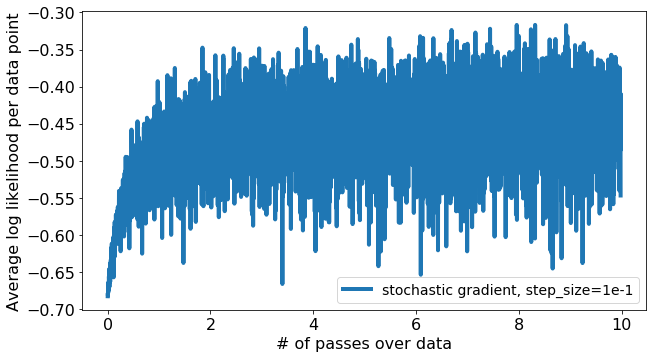

In [58]:
make_plot(log_likelihood_all3,len_data,100,label='stochastic gradient, step_size=1e-1')

## Stochastic gradient ascent vs batch gradient ascent

In [65]:
init_wts = np.zeros(194)
step = 1e-1
batch_size = 100

num_passes = 200
max_iter = num_passes * int( ( len(feat_mat_train) / batch_size ) )

In [66]:
## stochastic gradient ascent
wts4, log_likelihood_all4 = logistic_regression_SG(feat_mat_train, sent_train,init_wts,step,batch_size,max_iter)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

In [ ]:
## batch gradient ascent
## use wts2, log_likelihood_all2

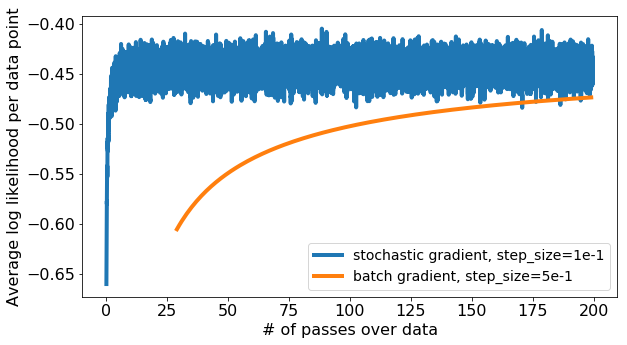

In [74]:
make_plot(log_likelihood_all4,len_data,100,30,label='stochastic gradient, step_size=1e-1')
make_plot(log_likelihood_all2,len_data,len_data,30,label='batch gradient, step_size=5e-1')

## effects of step sizes on stochastic gradient ascent

In [71]:
step_size = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
init_wts = np.zeros(194)
batch_size = 100

num_passes = 10
max_iter = num_passes * int( ( len(feat_mat_train) / batch_size ) )

In [72]:
log_likelihood_list = []
wts_list = []

for step in step_size:
    
    wts,log_likelihood_all = logistic_regression_SG(feat_mat_train, sent_train,init_wts,step,batch_size,max_iter)

    wts_list.append(wts)
    log_likelihood_list.append(log_likelihood_all)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

Iteration  300: Average log likelihood (of data points  [30000:30100]) = -0.48245740
Iteration  400: Average log likelihood (of data points  [40000:40100]) = -0.46629313
Iteration  500: Average log likelihood (of data points  [02300:02400]) = -0.47223389
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -0.52216798
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -0.52336683
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -0.46963453
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -0.47883783
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -0.46988191
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -0.46365531
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -0.36466901
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -0.51096892
Iteration 4769: Average log likelihood (of data points  [47600:47

Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -3.13066432
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -13.71853792
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -2.60719490
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -15.53337641
Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -30.39979776


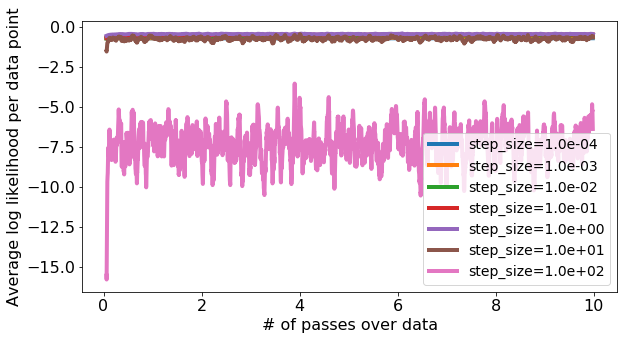

In [77]:
for i,step in enumerate(step_size):
    make_plot(log_likelihood_list[i],len_data,100,30,label='step_size=%.1e'%step)

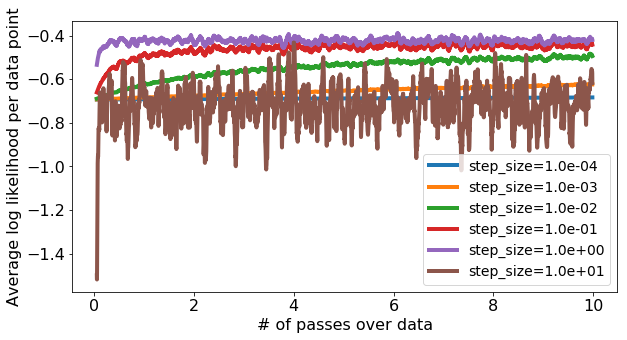

In [79]:
## remove step 1e2
step_size = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

for i,step in enumerate(step_size):
    make_plot(log_likelihood_list[i],len_data,100,30,label='step_size=%.1e'%step)

In [80]:
train.shape

(47780, 199)

In [81]:
feat_mat_train.shape

(47780, 194)